# Online Ridge regression

In [4]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

In [171]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

In [9]:
key = jax.random.PRNGKey(314)
key_x, key_y, key_coef = jax.random.split(key, 3)

In [116]:
m = 2
n_samples = 1000

coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8])
X = jax.random.uniform(key_x, (n_samples, m))
errs = jax.random.normal(key_y, (n_samples,))
y = jnp.einsum("sm,m->s", X, coefs) + errs
y = jnp.atleast_2d(y).T

In [117]:
coefs

Array([0.1, 0.8], dtype=float32)

In [118]:
alpha = 1.0

In [128]:
mu_ridge = jnp.linalg.solve(X.T @ X + jnp.eye(m) * alpha, X.T @ y)

In [155]:
r = 1.0

I = jnp.eye(m)
def step(coef, xs):
    mu, cov = coef
    y, x, = xs

    S = x.T @ cov @ x + r
    K = cov @ x @ jnp.linalg.inv(S)
    
    mu = mu + K @ (y - mu.T @ x)
    cov = (I - K @ x.T) @ cov

    return (mu, cov), (mu, cov)

In [156]:
params = (jnp.zeros(m), I)
(mu, cov), (mu_vals, cov_vals) = jax.lax.scan(step, params, (y, X[..., None]))

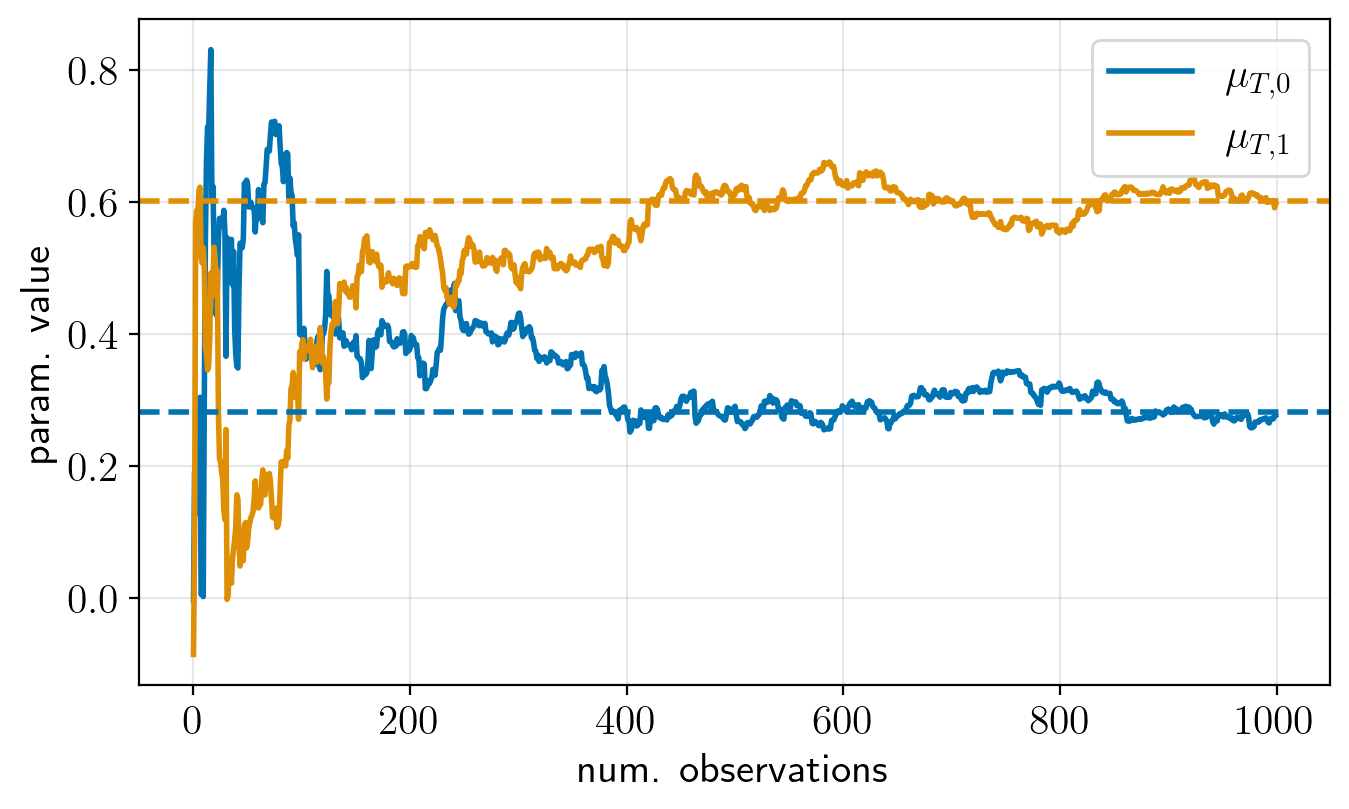

In [179]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.9))

plt.plot(mu_vals, label=[r"$\mu_{T,0}$", r"$\mu_{T,1}$"])
for i, p in enumerate(mu_ridge):
    color = sns.color_palette()[i]
    plt.axhline(p, color=color, linestyle="--")

plt.legend()
plt.ylabel("param. value")
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

plt.savefig("../figures/ch01-ridge-online.png", dpi=300, bbox_inches="tight")